# CS987 Comparative Analysis of CNN and Vision Transformer on CIFAR-10 Image Classification

## Introduction

In this notebook, we focus on classifying images from the CIFAR-10 dataset. We explore two architectures: a Convolutional Neural Network (CNN) and a VisionTransformer (ViT). The goal is to analyse and compare their performance in terms of accuracy, computational efficiency, and generalisation ability.
We utilise Python libraries such as Pandas for data handling, NumPy for numerical operations, and Matplotlib for visualisation. Additionally, we use torch libraries to support neural network tasks such as data preprocessing, model architecture design, training and evaluation. Itertools is adopted for hyperparameter tuning.

## Data preprocessing

### Loading libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import itertools
from tqdm import tqdm

### Load Data

In [ ]:
# Device configuration - use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

When working with images, we typically convert them to tensors so PyTorch can handle them. Then, normalisation is huge; it keeps pixel values in a nice range around 0, which often helps the model converge. Using (0.5, 0.5, 0.5) both as means and standard deviations is a common approach for CIFAR-10, basically shifting pixel values to be centered around 0.

In [ ]:
# Load CIFAR-10 dataset
full_train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train into train + val
train_size = int(0.9 * len(full_train_data))  # 90% train
val_size = len(full_train_data) - train_size  # 10% validation
train_data, val_data = random_split(full_train_data, [train_size, val_size])

# Loaders
loaders = {
    'train': DataLoader(train_data, batch_size=256, shuffle=True, num_workers=1),
    'val': DataLoader(val_data, batch_size=256, shuffle=False, num_workers=1),
    'test': DataLoader(test_data, batch_size=256, shuffle=False, num_workers=1)
}

CIFAR-10 has 50,000 training images. An 80/20 split yields 40,000 for training and 10,000 for validation. However, a 90/10 split uses 45,000 for training and 5,000 for validation, which is typically enough for a reliable estimate. The extra training data can boost performance, especially with deeper networks.
Now for each split — train, val, and test — we create a DataLoader. The batch size is set to 256; that’s a decent size for modern GPUs without overheating. For training, we shuffle the data each epoch to reduce correlation between consecutive samples. For validation and test, opted for no shuffle, because it doesn’t matter for performance metrics—plus it keeps the data loading consistent.

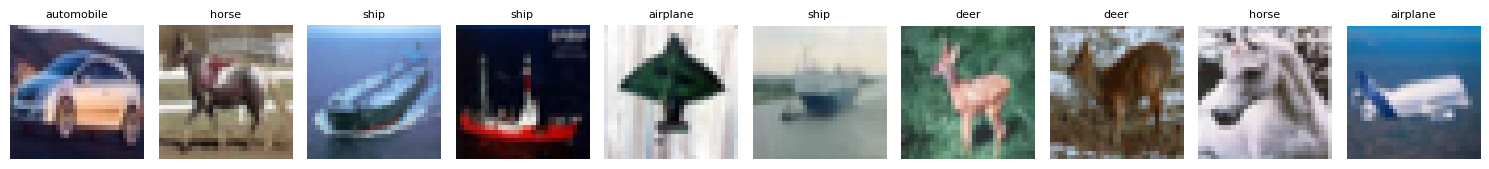

In [ ]:
# CIFAR-10 class names
class_names = full_train_data.classes

# Denormalisation function
def denormalize(img_tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return img_tensor * std + mean

# Set up 1 row of images
num_images = 10
figure = plt.figure(figsize=(15, 2))

for i in range(1, num_images + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]

    img = denormalize(img).permute(1, 2, 0).numpy()  # (H, W, C)

    ax = figure.add_subplot(1, num_images, i)
    ax.set_title(class_names[label], fontsize=8)
    ax.axis("off")
    plt.imshow(img)

plt.tight_layout()
plt.show()

Here, we de-normalise images so they look natural when displayed, then plot a row of 10 random samples.\
Each subplot is labeled with its class name, providing a quick sense check that images and labels align correctly.

## Model Implementation

### Build CNN Model

In [ ]:
class CIFAR10_CNN(nn.Module):
    def __init__(self, conv1_channels=64, conv2_channels=128, conv3_channels=256,
                 fc1_units=512, dropout1=0.25, dropout2=0.3, dropout3=0.4, dropout_fc=0.5):
        super(CIFAR10_CNN, self).__init__()

    # First convolutional block:
    # Two convolution layers with batch normalization and ReLU to extract low-level features.
    # A kernel size of 5 is chosen to capture more spatial context in the early layer.
    # Max pooling is applied to downsample the feature maps.
    # Dropout (dropout1) is used to prevent overfitting.
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, conv1_channels, 5, stride=1, padding=2), nn.BatchNorm2d(conv1_channels), nn.ReLU(),
            nn.Conv2d(conv1_channels, conv1_channels, 5, stride=1, padding=2), nn.BatchNorm2d(conv1_channels), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout1)
        )

    # Second convolutional block:
    # Two layers with kernel size 3 to learn more detailed features.
    # Increased channel dimension to allow for learning more complex patterns.
    # Batch normalisation follows each convolution to stabilise training.
    # Dropout (dropout2) is used after pooling for regularisation.
        self.conv2 = nn.Sequential(
            nn.Conv2d(conv1_channels, conv2_channels, 3, stride=1, padding=1), nn.BatchNorm2d(conv2_channels), nn.ReLU(),
            nn.Conv2d(conv2_channels, conv2_channels, 3, stride=1, padding=0), nn.BatchNorm2d(conv2_channels), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout2)
        )

    # Third convolutional block:
    # A single convolutional layer is used with kernel size 3 to form deeper hierarchical features.
    # The feature map dimensions are further reduced with max pooling.
    # A slightly higher dropout (dropout3) is applied to provide stronger regularisation in deeper layers.
        self.conv3 = nn.Sequential(
            nn.Conv2d(conv2_channels, conv3_channels, 3, stride=1, padding=0), nn.BatchNorm2d(conv3_channels), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout3)
        )

    # Fully-connected layers:
    # The final feature maps from conv3 are flattened and passed through a dense layer.
    # A dropout (dropout_fc) is applied before the final classification layer to mitigate overfitting.
        self.fc1 = nn.Linear(conv3_channels * 2 * 2, fc1_units)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_fc)
        self.fc2 = nn.Linear(fc1_units, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CIFAR10_CNN().to(device)

Rationale behind the CNN design:

- The number of convolutional layers (three blocks) was chosen to adequately capture features at varying scales.
- Dropout rates were chosen to balance between regularization and maintaining sufficient learning capacity.
- Alternatives such as residual connections were considered; however, given the relatively small size of the CIFAR-10 images and our exploratory focus, a simpler architecture provided clarity and adequate performance.
- Additional normalization layers were also considered, but the current batch normalisation consistently stabilises training.

### Build Vision Transformer

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, emb_dim=384,
                 num_layers=4, num_heads=6, ff_dim=128, num_classes=10, dropout=0.1):
        super(VisionTransformer, self).__init__()

        assert img_size % patch_size == 0, "Image size must be divisible by patch size"
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_dim = in_channels * patch_size * patch_size

        # Patch embedding: flatten patches and project to embedding dim
        self.patch_embed = nn.Linear(self.patch_dim, emb_dim)

        # [CLS] token for classification
        # A learnable token that will aggregate information from all patches.
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))

        # Learnable positional encoding
        # This helps the model retain spatial information after flattening the patches.
        self.pos_encoding = nn.Parameter(torch.randn(1, self.num_patches + 1, emb_dim))

        # Transformer encoder
        # Encoder uses multiple layers of multi-head self-attention.
        # The structure here is kept minimal. Alternatives like deeper networks or more heads were considered,
        # but the current configuration offers a balance between performance and computational cost.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, x):
        B, C, H, W = x.shape

        # Step 1: Create non-overlapping patches
        patch_size = int((self.patch_dim // C) ** 0.5)
        x = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)  # [B, C, n_patches_h, n_patches_w]
        x = x.contiguous().view(B, C, -1, patch_size, patch_size)
        x = x.permute(0, 2, 1, 3, 4)  # [B, num_patches, C, patch_size, patch_size]
        x = x.contiguous().view(B, self.num_patches, -1)  # [B, num_patches, patch_dim]

        # Step 2: Linear projection
        x = self.patch_embed(x)  # [B, num_patches, emb_dim]

        # Step 3: Add [CLS] token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, emb_dim]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, num_patches+1, emb_dim]

        # Step 4: Add positional encoding
        x = x + self.pos_encoding[:, :x.size(1), :]

        # Step 5: Transformer encoder
        x = self.encoder(x)  # [B, num_patches+1, emb_dim]

        # Step 6: Use [CLS] token output
        cls_output = x[:, 0, :]  # [B, emb_dim]

        # Step 7: Classification head
        out = self.mlp_head(cls_output)  # [B, num_classes]
        return out

model_vit = VisionTransformer().to(device)

Rationale behind the ViT design:
- Splitting images into patches and using a transformer allows the model to capture long-range dependencies.
- The embedding dimension, number of layers, and number of attention heads were chosen based on a trade-off between model capacity and computational cost.
- Alternatives like adding residual connections are inherent in the Transformer encoder design, but explicit extra skip connections were not added since the encoder layers already include residual paths.
- Additional normalisation layers (beyond the initial LayerNorm in the mlp_head) were considered redundant given the stabilising effect of the positional encodings and the built-in normalisation in the encoder layers

## Training and Optimisation

### Train, Test and Learning Curve Function

Training: We alternate between training (forward pass, loss calculation, backprop) and validation. Early stopping halts training if validation loss ceases to improve, preventing extreme overfitting. \
Testing: A separate function calculates final accuracy and loss on the test set. \
Learning Curves: We plot training vs. validation loss and accuracy across epochs to visualize convergence and potential over/underfitting.

In [ ]:
def train_model(model, loaders, criterion, optimizer, num_epochs=10, patience=5, checkpoint_path="best_cifar10_cnn.pth"):
    import copy

    # Tracks loss and accuracy during training.
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    # Early stopping parameters
    epochs_without_improvement = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Training
        for images, labels in loaders['train']:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)  # sum over batch
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in loaders['val']:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= total
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Early stopping:
        # This block monitors the validation loss after every epoch.
        # If the validation loss improves (i.e., decreases), we update the best_val_loss,
        # reset the counter (epochs_without_improvement) to zero, and save the model weights.
        # If not, we increment the counter. If the counter reaches the 'patience' threshold,
        # training is stopped early to prevent overfitting.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
            torch.save(best_model_wts, checkpoint_path)
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_wts)
    return train_losses, val_losses, train_accs, val_accs

In [ ]:
## This function evaluates the trained model on a given dataset loader.
# It computes both the loss and accuracy using the specified loss criterion.
def test_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss /= total
    test_acc = 100 * correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

In [ ]:
# This function generates plots for both training and validation loss, as well as accuracy curves over epochs.
# It helps visualise the model's convergence behavior and check for issues such as overfitting.
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.ylim(0, 2)  # Fixed y-axis scale
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Acc')
    plt.plot(epochs, val_accs, 'r-', label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.ylim(0, 100)  # Fixed y-axis scale
    plt.legend()
    plt.tight_layout()
    plt.show()

### Hyperparameter optimisation by grid search and training

### CNN training

We define a parameter grid for our CNN. The script loops over each combination, training briefly to gauge validation accuracy. \
This systematic search identifies the best hyperparameters (e.g., learning rate, channel sizes, dropout) under time constraints—useful for discovering well-tuned configurations.

Grid search is chosen here because:
- The hyperparameter space is relatively small and allows us to evaluate every combination.
- It provides clear insight into how different parameter combinations affect performance.
- The systematic exploration aids in understanding interactions between hyperparameters.

In [ ]:
param_grid = {
    'conv1_channels': [32, 64],
    'conv2_channels': [64, 128],
    'conv3_channels': [128, 256],
    'fc1_units': [256, 512],
    'dropout_fc': [0.3, 0.5],
    'lr': [0.001, 0.0005],
}
# Generate all possible hyperparameter combinations from the grid.
param_combinations = list(itertools.product(*param_grid.values()))

In [ ]:
best_val_acc = 0
best_config = None
results = []

for values in tqdm(param_combinations, desc="Grid Search"):
    params = dict(zip(param_grid.keys(), values))
    print(f"\nTesting config: {params}")

    model = CIFAR10_CNN(
        conv1_channels=params['conv1_channels'],
        conv2_channels=params['conv2_channels'],
        conv3_channels=params['conv3_channels'],
        fc1_units=params['fc1_units'],
        dropout_fc=params['dropout_fc']
    ).to(device)

    # The optimizer with the current learning rate.
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.CrossEntropyLoss()

    # Train model using your function (you can reduce num_epochs for faster search):
    # The early stopping implementation within the train_model function monitors validation loss.
    # - If the validation loss improves, it resets the 'no improvement' counter.
    # - If not, the counter increases. Once the counter reaches 'patience', training stops.
    # This helps to avoid overfitting and prevents training from continuing when no further improvement occurs.
    _, _, _, val_accs = train_model(model, loaders, criterion, optimizer, num_epochs=2)

    final_val_acc = val_accs[-1]
    results.append((params, final_val_acc))

    # Track best model
    if final_val_acc > best_val_acc:
        best_val_acc = final_val_acc
        best_config = params
        best_model = model  # Save the best model instance if you want to test later

print(f"\nBest Config: {best_config}")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

# Optionally test best model
print("\nEvaluating best model on test set:")
test_model(best_model, loaders['test'])

Grid Search:   0%|          | 0/64 [00:00<?, ?it/s]


Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.6005, Train Acc: 40.44% Val Loss: 1.2622, Val Acc: 54.96%


Grid Search:   2%|▏         | 1/64 [00:23<24:30, 23.34s/it]

Epoch [2/2] Train Loss: 1.2165, Train Acc: 55.93% Val Loss: 1.3347, Val Acc: 53.12%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6644, Train Acc: 37.67% Val Loss: 1.3635, Val Acc: 50.98%


Grid Search:   3%|▎         | 2/64 [00:45<23:31, 22.77s/it]

Epoch [2/2] Train Loss: 1.2953, Train Acc: 53.00% Val Loss: 1.1643, Val Acc: 58.82%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.6290, Train Acc: 39.03% Val Loss: 1.3768, Val Acc: 50.92%


Grid Search:   5%|▍         | 3/64 [01:08<23:07, 22.75s/it]

Epoch [2/2] Train Loss: 1.2342, Train Acc: 54.99% Val Loss: 1.2025, Val Acc: 57.36%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.7428, Train Acc: 34.24% Val Loss: 1.4242, Val Acc: 47.94%


Grid Search:   6%|▋         | 4/64 [01:31<22:41, 22.69s/it]

Epoch [2/2] Train Loss: 1.3576, Train Acc: 50.57% Val Loss: 1.1842, Val Acc: 56.82%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5431, Train Acc: 42.62% Val Loss: 1.3189, Val Acc: 52.42%


Grid Search:   8%|▊         | 5/64 [01:53<22:14, 22.62s/it]

Epoch [2/2] Train Loss: 1.1663, Train Acc: 57.70% Val Loss: 1.1834, Val Acc: 58.48%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6243, Train Acc: 39.04% Val Loss: 1.3406, Val Acc: 51.50%


Grid Search:   9%|▉         | 6/64 [02:16<21:52, 22.63s/it]

Epoch [2/2] Train Loss: 1.2486, Train Acc: 54.86% Val Loss: 1.1309, Val Acc: 59.22%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5965, Train Acc: 40.31% Val Loss: 1.2623, Val Acc: 54.10%


Grid Search:  11%|█         | 7/64 [02:38<21:26, 22.58s/it]

Epoch [2/2] Train Loss: 1.2207, Train Acc: 55.72% Val Loss: 1.2320, Val Acc: 56.56%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6914, Train Acc: 36.54% Val Loss: 1.4065, Val Acc: 49.20%


Grid Search:  12%|█▎        | 8/64 [03:01<21:01, 22.53s/it]

Epoch [2/2] Train Loss: 1.3141, Train Acc: 52.12% Val Loss: 1.1724, Val Acc: 57.06%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5571, Train Acc: 42.27% Val Loss: 1.2879, Val Acc: 53.68%


Grid Search:  14%|█▍        | 9/64 [03:23<20:31, 22.40s/it]

Epoch [2/2] Train Loss: 1.1733, Train Acc: 57.64% Val Loss: 1.0048, Val Acc: 63.74%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6199, Train Acc: 39.54% Val Loss: 1.3817, Val Acc: 49.60%


Grid Search:  16%|█▌        | 10/64 [03:45<20:04, 22.30s/it]

Epoch [2/2] Train Loss: 1.2497, Train Acc: 54.89% Val Loss: 1.1078, Val Acc: 60.52%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.6187, Train Acc: 39.85% Val Loss: 1.2840, Val Acc: 52.88%


Grid Search:  17%|█▋        | 11/64 [04:07<19:42, 22.30s/it]

Epoch [2/2] Train Loss: 1.2292, Train Acc: 55.70% Val Loss: 1.0865, Val Acc: 60.06%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6875, Train Acc: 36.88% Val Loss: 1.4648, Val Acc: 45.40%


Grid Search:  19%|█▉        | 12/64 [04:29<19:20, 22.31s/it]

Epoch [2/2] Train Loss: 1.2939, Train Acc: 53.02% Val Loss: 1.1612, Val Acc: 58.34%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5405, Train Acc: 43.05% Val Loss: 1.2004, Val Acc: 56.30%


Grid Search:  20%|██        | 13/64 [04:52<19:05, 22.45s/it]

Epoch [2/2] Train Loss: 1.1459, Train Acc: 58.84% Val Loss: 1.0186, Val Acc: 63.20%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.5743, Train Acc: 41.66% Val Loss: 1.3443, Val Acc: 51.06%


Grid Search:  22%|██▏       | 14/64 [05:15<18:44, 22.49s/it]

Epoch [2/2] Train Loss: 1.2030, Train Acc: 56.65% Val Loss: 1.1643, Val Acc: 58.32%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.6008, Train Acc: 40.21% Val Loss: 1.4194, Val Acc: 48.36%


Grid Search:  23%|██▎       | 15/64 [05:37<18:23, 22.52s/it]

Epoch [2/2] Train Loss: 1.2305, Train Acc: 55.64% Val Loss: 1.0660, Val Acc: 61.58%

Testing config: {'conv1_channels': 32, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6593, Train Acc: 38.07% Val Loss: 1.4307, Val Acc: 47.74%


Grid Search:  25%|██▌       | 16/64 [06:00<18:03, 22.57s/it]

Epoch [2/2] Train Loss: 1.2704, Train Acc: 53.66% Val Loss: 1.1519, Val Acc: 57.70%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5261, Train Acc: 43.54% Val Loss: 1.2413, Val Acc: 55.64%


Grid Search:  27%|██▋       | 17/64 [06:23<17:42, 22.60s/it]

Epoch [2/2] Train Loss: 1.1271, Train Acc: 59.44% Val Loss: 1.0064, Val Acc: 63.56%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.5875, Train Acc: 40.84% Val Loss: 1.3040, Val Acc: 52.58%


Grid Search:  28%|██▊       | 18/64 [06:45<17:16, 22.53s/it]

Epoch [2/2] Train Loss: 1.1919, Train Acc: 57.03% Val Loss: 1.1352, Val Acc: 59.18%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5974, Train Acc: 40.58% Val Loss: 1.2890, Val Acc: 55.14%


Grid Search:  30%|██▉       | 19/64 [07:07<16:50, 22.46s/it]

Epoch [2/2] Train Loss: 1.1766, Train Acc: 58.08% Val Loss: 0.9828, Val Acc: 63.92%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6704, Train Acc: 37.62% Val Loss: 1.4940, Val Acc: 48.24%


Grid Search:  31%|███▏      | 20/64 [07:30<16:25, 22.40s/it]

Epoch [2/2] Train Loss: 1.2579, Train Acc: 54.53% Val Loss: 1.1860, Val Acc: 57.96%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5088, Train Acc: 44.14% Val Loss: 1.3942, Val Acc: 51.40%


Grid Search:  33%|███▎      | 21/64 [07:52<16:04, 22.44s/it]

Epoch [2/2] Train Loss: 1.1178, Train Acc: 60.07% Val Loss: 1.1464, Val Acc: 60.24%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.5481, Train Acc: 42.47% Val Loss: 1.3161, Val Acc: 53.42%


Grid Search:  34%|███▍      | 22/64 [08:15<15:42, 22.44s/it]

Epoch [2/2] Train Loss: 1.1685, Train Acc: 57.71% Val Loss: 0.9974, Val Acc: 64.06%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5597, Train Acc: 42.02% Val Loss: 1.2488, Val Acc: 55.20%


Grid Search:  36%|███▌      | 23/64 [08:37<15:21, 22.47s/it]

Epoch [2/2] Train Loss: 1.1670, Train Acc: 58.11% Val Loss: 1.0536, Val Acc: 62.10%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6266, Train Acc: 39.16% Val Loss: 1.2967, Val Acc: 53.40%


Grid Search:  38%|███▊      | 24/64 [09:00<14:57, 22.43s/it]

Epoch [2/2] Train Loss: 1.2314, Train Acc: 55.39% Val Loss: 1.3565, Val Acc: 53.80%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5042, Train Acc: 44.57% Val Loss: 1.2122, Val Acc: 56.88%


Grid Search:  39%|███▉      | 25/64 [09:22<14:35, 22.44s/it]

Epoch [2/2] Train Loss: 1.0957, Train Acc: 60.65% Val Loss: 1.0396, Val Acc: 62.34%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.5558, Train Acc: 42.22% Val Loss: 1.2212, Val Acc: 55.16%


Grid Search:  41%|████      | 26/64 [09:44<14:12, 22.44s/it]

Epoch [2/2] Train Loss: 1.1528, Train Acc: 58.42% Val Loss: 1.0799, Val Acc: 61.60%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5752, Train Acc: 41.37% Val Loss: 1.3238, Val Acc: 53.06%


Grid Search:  42%|████▏     | 27/64 [10:07<13:48, 22.39s/it]

Epoch [2/2] Train Loss: 1.1749, Train Acc: 58.06% Val Loss: 1.0500, Val Acc: 62.52%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6253, Train Acc: 39.90% Val Loss: 1.3218, Val Acc: 51.76%


Grid Search:  44%|████▍     | 28/64 [10:29<13:26, 22.41s/it]

Epoch [2/2] Train Loss: 1.2201, Train Acc: 56.29% Val Loss: 1.0145, Val Acc: 63.58%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.4814, Train Acc: 44.99% Val Loss: 1.2364, Val Acc: 56.26%


Grid Search:  45%|████▌     | 29/64 [10:52<13:05, 22.44s/it]

Epoch [2/2] Train Loss: 1.0731, Train Acc: 61.70% Val Loss: 0.9195, Val Acc: 67.42%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.5428, Train Acc: 42.70% Val Loss: 1.3832, Val Acc: 50.52%


Grid Search:  47%|████▋     | 30/64 [11:14<12:41, 22.38s/it]

Epoch [2/2] Train Loss: 1.1544, Train Acc: 58.45% Val Loss: 1.0199, Val Acc: 63.64%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5563, Train Acc: 42.52% Val Loss: 1.3442, Val Acc: 51.58%


Grid Search:  48%|████▊     | 31/64 [11:37<12:22, 22.49s/it]

Epoch [2/2] Train Loss: 1.1518, Train Acc: 58.62% Val Loss: 0.9970, Val Acc: 64.76%

Testing config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6137, Train Acc: 40.03% Val Loss: 1.3712, Val Acc: 49.72%


Grid Search:  50%|█████     | 32/64 [12:00<12:06, 22.70s/it]

Epoch [2/2] Train Loss: 1.2033, Train Acc: 56.50% Val Loss: 1.0969, Val Acc: 60.28%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5615, Train Acc: 41.92% Val Loss: 1.3542, Val Acc: 50.20%


Grid Search:  52%|█████▏    | 33/64 [12:23<11:50, 22.93s/it]

Epoch [2/2] Train Loss: 1.1608, Train Acc: 58.24% Val Loss: 1.1918, Val Acc: 57.42%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6334, Train Acc: 38.79% Val Loss: 1.3138, Val Acc: 51.84%


Grid Search:  53%|█████▎    | 34/64 [12:46<11:27, 22.92s/it]

Epoch [2/2] Train Loss: 1.2177, Train Acc: 55.81% Val Loss: 1.1302, Val Acc: 58.24%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.6379, Train Acc: 38.92% Val Loss: 1.4165, Val Acc: 49.16%


Grid Search:  55%|█████▍    | 35/64 [13:09<11:05, 22.95s/it]

Epoch [2/2] Train Loss: 1.2268, Train Acc: 55.72% Val Loss: 1.0633, Val Acc: 61.66%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.7083, Train Acc: 35.70% Val Loss: 1.3712, Val Acc: 48.72%


Grid Search:  56%|█████▋    | 36/64 [13:32<10:40, 22.87s/it]

Epoch [2/2] Train Loss: 1.2581, Train Acc: 54.32% Val Loss: 1.2113, Val Acc: 56.90%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5189, Train Acc: 43.22% Val Loss: 1.1955, Val Acc: 56.72%


Grid Search:  58%|█████▊    | 37/64 [13:55<10:17, 22.88s/it]

Epoch [2/2] Train Loss: 1.1073, Train Acc: 60.06% Val Loss: 0.9430, Val Acc: 66.04%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6227, Train Acc: 39.39% Val Loss: 1.3956, Val Acc: 48.98%


Grid Search:  59%|█████▉    | 38/64 [14:18<09:54, 22.87s/it]

Epoch [2/2] Train Loss: 1.2119, Train Acc: 56.24% Val Loss: 1.0695, Val Acc: 61.68%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5892, Train Acc: 40.91% Val Loss: 1.2317, Val Acc: 55.34%


Grid Search:  61%|██████    | 39/64 [14:41<09:32, 22.88s/it]

Epoch [2/2] Train Loss: 1.1846, Train Acc: 57.12% Val Loss: 1.2248, Val Acc: 57.04%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6343, Train Acc: 38.67% Val Loss: 1.3220, Val Acc: 50.68%


Grid Search:  62%|██████▎   | 40/64 [15:04<09:09, 22.91s/it]

Epoch [2/2] Train Loss: 1.2154, Train Acc: 56.26% Val Loss: 1.0724, Val Acc: 61.96%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5553, Train Acc: 42.26% Val Loss: 1.2099, Val Acc: 56.82%


Grid Search:  64%|██████▍   | 41/64 [15:26<08:46, 22.91s/it]

Epoch [2/2] Train Loss: 1.1194, Train Acc: 59.59% Val Loss: 0.9590, Val Acc: 65.08%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.5975, Train Acc: 40.42% Val Loss: 1.2649, Val Acc: 54.24%


Grid Search:  66%|██████▌   | 42/64 [15:49<08:22, 22.84s/it]

Epoch [2/2] Train Loss: 1.1851, Train Acc: 57.40% Val Loss: 1.0574, Val Acc: 61.86%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.6117, Train Acc: 39.81% Val Loss: 1.3148, Val Acc: 52.54%


Grid Search:  67%|██████▋   | 43/64 [16:12<07:59, 22.82s/it]

Epoch [2/2] Train Loss: 1.2024, Train Acc: 56.69% Val Loss: 1.0401, Val Acc: 62.22%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6676, Train Acc: 37.89% Val Loss: 1.3456, Val Acc: 51.66%


Grid Search:  69%|██████▉   | 44/64 [16:35<07:37, 22.87s/it]

Epoch [2/2] Train Loss: 1.2470, Train Acc: 54.77% Val Loss: 1.0912, Val Acc: 60.40%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5337, Train Acc: 42.91% Val Loss: 1.2910, Val Acc: 53.38%


Grid Search:  70%|███████   | 45/64 [16:58<07:14, 22.87s/it]

Epoch [2/2] Train Loss: 1.1154, Train Acc: 60.08% Val Loss: 1.0363, Val Acc: 63.10%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.5449, Train Acc: 42.79% Val Loss: 1.2557, Val Acc: 54.94%


Grid Search:  72%|███████▏  | 46/64 [17:20<06:50, 22.79s/it]

Epoch [2/2] Train Loss: 1.1439, Train Acc: 58.86% Val Loss: 1.0857, Val Acc: 59.96%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5711, Train Acc: 41.57% Val Loss: 1.2844, Val Acc: 52.74%


Grid Search:  73%|███████▎  | 47/64 [17:43<06:27, 22.81s/it]

Epoch [2/2] Train Loss: 1.1595, Train Acc: 58.28% Val Loss: 1.0536, Val Acc: 61.62%

Testing config: {'conv1_channels': 64, 'conv2_channels': 64, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6124, Train Acc: 39.67% Val Loss: 1.3061, Val Acc: 53.58%


Grid Search:  75%|███████▌  | 48/64 [18:06<06:05, 22.82s/it]

Epoch [2/2] Train Loss: 1.2011, Train Acc: 56.64% Val Loss: 1.0795, Val Acc: 61.44%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5151, Train Acc: 43.84% Val Loss: 1.1343, Val Acc: 58.42%


Grid Search:  77%|███████▋  | 49/64 [18:30<05:49, 23.29s/it]

Epoch [2/2] Train Loss: 1.0930, Train Acc: 60.94% Val Loss: 1.2470, Val Acc: 57.90%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.5862, Train Acc: 41.10% Val Loss: 1.1895, Val Acc: 57.00%


Grid Search:  78%|███████▊  | 50/64 [18:55<05:31, 23.68s/it]

Epoch [2/2] Train Loss: 1.1472, Train Acc: 58.86% Val Loss: 1.0364, Val Acc: 62.44%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5896, Train Acc: 40.94% Val Loss: 1.2510, Val Acc: 54.88%


Grid Search:  80%|███████▉  | 51/64 [19:20<05:11, 23.95s/it]

Epoch [2/2] Train Loss: 1.1583, Train Acc: 58.40% Val Loss: 0.9578, Val Acc: 66.30%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6398, Train Acc: 38.54% Val Loss: 1.2407, Val Acc: 54.66%


Grid Search:  81%|████████▏ | 52/64 [19:44<04:49, 24.11s/it]

Epoch [2/2] Train Loss: 1.1969, Train Acc: 56.65% Val Loss: 1.0433, Val Acc: 61.76%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5133, Train Acc: 43.67% Val Loss: 1.2576, Val Acc: 55.02%


Grid Search:  83%|████████▎ | 53/64 [20:09<04:26, 24.25s/it]

Epoch [2/2] Train Loss: 1.0875, Train Acc: 61.11% Val Loss: 0.9287, Val Acc: 65.94%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.5395, Train Acc: 42.89% Val Loss: 1.4255, Val Acc: 51.38%


Grid Search:  84%|████████▍ | 54/64 [20:33<04:03, 24.35s/it]

Epoch [2/2] Train Loss: 1.1191, Train Acc: 59.61% Val Loss: 1.0158, Val Acc: 62.60%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5042, Train Acc: 44.23% Val Loss: 1.1887, Val Acc: 57.88%


Grid Search:  86%|████████▌ | 55/64 [20:58<03:39, 24.44s/it]

Epoch [2/2] Train Loss: 1.0937, Train Acc: 60.87% Val Loss: 0.9731, Val Acc: 64.58%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 128, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.6089, Train Acc: 39.78% Val Loss: 1.2878, Val Acc: 53.24%


Grid Search:  88%|████████▊ | 56/64 [21:23<03:15, 24.50s/it]

Epoch [2/2] Train Loss: 1.1785, Train Acc: 57.51% Val Loss: 1.0100, Val Acc: 63.96%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5039, Train Acc: 44.23% Val Loss: 1.1769, Val Acc: 57.54%


Grid Search:  89%|████████▉ | 57/64 [21:48<02:53, 24.77s/it]

Epoch [2/2] Train Loss: 1.0692, Train Acc: 61.73% Val Loss: 1.0069, Val Acc: 63.28%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.5156, Train Acc: 43.74% Val Loss: 1.3074, Val Acc: 52.90%


Grid Search:  91%|█████████ | 58/64 [22:13<02:29, 24.96s/it]

Epoch [2/2] Train Loss: 1.0913, Train Acc: 61.01% Val Loss: 0.9747, Val Acc: 64.64%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5680, Train Acc: 42.13% Val Loss: 1.2429, Val Acc: 53.96%


Grid Search:  92%|█████████▏| 59/64 [22:39<02:05, 25.10s/it]

Epoch [2/2] Train Loss: 1.1300, Train Acc: 59.34% Val Loss: 1.0353, Val Acc: 62.64%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 256, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.5852, Train Acc: 40.91% Val Loss: 1.2194, Val Acc: 56.08%


Grid Search:  94%|█████████▍| 60/64 [23:04<01:40, 25.20s/it]

Epoch [2/2] Train Loss: 1.1534, Train Acc: 58.57% Val Loss: 1.0129, Val Acc: 64.58%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.4735, Train Acc: 45.47% Val Loss: 1.1314, Val Acc: 59.26%


Grid Search:  95%|█████████▌| 61/64 [23:30<01:15, 25.32s/it]

Epoch [2/2] Train Loss: 1.0469, Train Acc: 62.71% Val Loss: 0.9248, Val Acc: 67.02%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.5014, Train Acc: 44.46% Val Loss: 1.1489, Val Acc: 58.20%


Grid Search:  97%|█████████▋| 62/64 [23:55<00:50, 25.37s/it]

Epoch [2/2] Train Loss: 1.0745, Train Acc: 61.45% Val Loss: 1.0200, Val Acc: 63.20%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.5450, Train Acc: 43.01% Val Loss: 1.2556, Val Acc: 52.92%


Grid Search:  98%|█████████▊| 63/64 [24:21<00:25, 25.41s/it]

Epoch [2/2] Train Loss: 1.1053, Train Acc: 60.41% Val Loss: 1.0388, Val Acc: 64.12%

Testing config: {'conv1_channels': 64, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.5, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.5651, Train Acc: 41.33% Val Loss: 1.3023, Val Acc: 52.48%


Grid Search: 100%|██████████| 64/64 [24:46<00:00, 23.23s/it]

Epoch [2/2] Train Loss: 1.1425, Train Acc: 58.92% Val Loss: 0.9726, Val Acc: 65.32%

Best Config: {'conv1_channels': 32, 'conv2_channels': 128, 'conv3_channels': 256, 'fc1_units': 512, 'dropout_fc': 0.3, 'lr': 0.001}
Best Validation Accuracy: 67.42%

Evaluating best model on test set:


Test Accuracy: 67.74%


In [ ]:
# use the parameter determined by above grid search
model = CIFAR10_CNN(
    conv1_channels=32,
    conv2_channels=128,
    conv3_channels=256,
    fc1_units=512,
    dropout_fc=0.3
)
model.to(device)

CIFAR10_CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.

### Vision transformer training

The hyperparameters and grid search parameters are kept the same for vision transformer training to allow for to be compared for analysis and consistency.

In [ ]:
param_grid_vit = {
    'emb_dim': [192, 384],
    'num_layers': [2, 4],
    'num_heads': [3, 6],
    'ff_dim': [128, 256],
    'dropout': [0.1, 0.2],
    'lr': [0.001, 0.0005]
}
param_combinations_vit = list(itertools.product(*param_grid_vit.values()))

In [ ]:
best_val_acc = 0
best_config = None
vit_results = []

for values in tqdm(param_combinations_vit, desc="Grid Search ViT"):
    params = dict(zip(param_grid_vit.keys(), values))
    print(f"\nTesting config: {params}")

    model = VisionTransformer(
        img_size=32,
        patch_size=4,
        in_channels=3,
        emb_dim=params['emb_dim'],
        num_layers=params['num_layers'],
        num_heads=params['num_heads'],
        ff_dim=params['ff_dim'],
        dropout=params['dropout'],
        num_classes=10
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.CrossEntropyLoss()

    _, _, _, val_accs = train_model(model, loaders, criterion, optimizer, num_epochs=2)
    final_val_acc = val_accs[-1]

    vit_results.append((params, final_val_acc))

    if final_val_acc > best_val_acc:
        best_val_acc = final_val_acc
        best_config = params
        best_model = model  # Save best model

print(f"\nBest Config (ViT): {best_config}")
print(f"Best Validation Accuracy (ViT): {best_val_acc:.2f}%")

print("\nEvaluating best ViT model on test set:")
test_model(best_model, loaders['test'])

Grid Search ViT:   0%|          | 0/64 [00:00<?, ?it/s]


Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8367, Train Acc: 32.85% Val Loss: 1.5719, Val Acc: 43.14%


Grid Search ViT:   2%|▏         | 1/64 [00:22<23:59, 22.85s/it]

Epoch [2/2] Train Loss: 1.5557, Train Acc: 43.78% Val Loss: 1.4460, Val Acc: 47.82%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8878, Train Acc: 31.15% Val Loss: 1.6770, Val Acc: 39.30%


Grid Search ViT:   3%|▎         | 2/64 [00:45<23:39, 22.89s/it]

Epoch [2/2] Train Loss: 1.6410, Train Acc: 41.09% Val Loss: 1.5091, Val Acc: 45.40%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8459, Train Acc: 32.85% Val Loss: 1.6239, Val Acc: 41.64%


Grid Search ViT:   5%|▍         | 3/64 [01:08<23:10, 22.79s/it]

Epoch [2/2] Train Loss: 1.5881, Train Acc: 42.92% Val Loss: 1.4850, Val Acc: 45.54%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8897, Train Acc: 31.09% Val Loss: 1.6789, Val Acc: 39.46%


Grid Search ViT:   6%|▋         | 4/64 [01:31<22:46, 22.77s/it]

Epoch [2/2] Train Loss: 1.6530, Train Acc: 40.47% Val Loss: 1.5171, Val Acc: 45.68%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8558, Train Acc: 32.55% Val Loss: 1.6518, Val Acc: 40.24%


Grid Search ViT:   8%|▊         | 5/64 [01:53<22:18, 22.69s/it]

Epoch [2/2] Train Loss: 1.5744, Train Acc: 43.26% Val Loss: 1.4917, Val Acc: 45.90%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8857, Train Acc: 31.06% Val Loss: 1.6648, Val Acc: 39.74%


Grid Search ViT:   9%|▉         | 6/64 [02:16<21:58, 22.73s/it]

Epoch [2/2] Train Loss: 1.6003, Train Acc: 42.39% Val Loss: 1.5072, Val Acc: 45.98%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8472, Train Acc: 32.35% Val Loss: 1.6384, Val Acc: 38.94%


Grid Search ViT:  11%|█         | 7/64 [02:39<21:32, 22.68s/it]

Epoch [2/2] Train Loss: 1.5841, Train Acc: 42.62% Val Loss: 1.4582, Val Acc: 47.18%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.9003, Train Acc: 30.38% Val Loss: 1.6875, Val Acc: 38.82%


Grid Search ViT:  12%|█▎        | 8/64 [03:01<21:10, 22.70s/it]

Epoch [2/2] Train Loss: 1.6535, Train Acc: 40.74% Val Loss: 1.5382, Val Acc: 44.50%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.7942, Train Acc: 34.91% Val Loss: 1.5683, Val Acc: 43.46%


Grid Search ViT:  14%|█▍        | 9/64 [03:24<20:46, 22.67s/it]

Epoch [2/2] Train Loss: 1.5152, Train Acc: 45.54% Val Loss: 1.4340, Val Acc: 48.10%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8649, Train Acc: 32.20% Val Loss: 1.6279, Val Acc: 41.08%


Grid Search ViT:  16%|█▌        | 10/64 [03:47<20:27, 22.72s/it]

Epoch [2/2] Train Loss: 1.5631, Train Acc: 43.94% Val Loss: 1.4513, Val Acc: 47.38%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8260, Train Acc: 33.56% Val Loss: 1.5545, Val Acc: 43.78%


Grid Search ViT:  17%|█▋        | 11/64 [04:09<20:00, 22.65s/it]

Epoch [2/2] Train Loss: 1.5510, Train Acc: 43.84% Val Loss: 1.4275, Val Acc: 48.16%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8754, Train Acc: 31.69% Val Loss: 1.6395, Val Acc: 40.16%


Grid Search ViT:  19%|█▉        | 12/64 [04:32<19:41, 22.72s/it]

Epoch [2/2] Train Loss: 1.6186, Train Acc: 41.57% Val Loss: 1.4875, Val Acc: 46.44%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.7911, Train Acc: 34.81% Val Loss: 1.5257, Val Acc: 45.60%


Grid Search ViT:  20%|██        | 13/64 [04:55<19:16, 22.68s/it]

Epoch [2/2] Train Loss: 1.5026, Train Acc: 45.82% Val Loss: 1.4577, Val Acc: 47.78%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8611, Train Acc: 32.14% Val Loss: 1.6316, Val Acc: 40.90%


Grid Search ViT:  22%|██▏       | 14/64 [05:18<18:59, 22.78s/it]

Epoch [2/2] Train Loss: 1.5797, Train Acc: 43.19% Val Loss: 1.4695, Val Acc: 46.64%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8296, Train Acc: 33.24% Val Loss: 1.5660, Val Acc: 42.32%


Grid Search ViT:  23%|██▎       | 15/64 [05:41<18:37, 22.81s/it]

Epoch [2/2] Train Loss: 1.5468, Train Acc: 44.44% Val Loss: 1.4157, Val Acc: 48.42%

Testing config: {'emb_dim': 192, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8600, Train Acc: 32.36% Val Loss: 1.6190, Val Acc: 41.96%


Grid Search ViT:  25%|██▌       | 16/64 [06:04<18:29, 23.11s/it]

Epoch [2/2] Train Loss: 1.5896, Train Acc: 42.81% Val Loss: 1.4446, Val Acc: 48.08%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8121, Train Acc: 34.28% Val Loss: 1.6056, Val Acc: 41.38%


Grid Search ViT:  27%|██▋       | 17/64 [06:33<19:23, 24.75s/it]

Epoch [2/2] Train Loss: 1.5340, Train Acc: 44.66% Val Loss: 1.4739, Val Acc: 46.40%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8324, Train Acc: 33.34% Val Loss: 1.6438, Val Acc: 41.02%


Grid Search ViT:  28%|██▊       | 18/64 [07:02<19:52, 25.93s/it]

Epoch [2/2] Train Loss: 1.5555, Train Acc: 43.92% Val Loss: 1.4575, Val Acc: 46.62%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8276, Train Acc: 33.15% Val Loss: 1.5891, Val Acc: 43.26%


Grid Search ViT:  30%|██▉       | 19/64 [07:30<20:01, 26.70s/it]

Epoch [2/2] Train Loss: 1.5536, Train Acc: 44.11% Val Loss: 1.4341, Val Acc: 47.70%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8547, Train Acc: 32.34% Val Loss: 1.6270, Val Acc: 40.98%


Grid Search ViT:  31%|███▏      | 20/64 [07:59<19:59, 27.27s/it]

Epoch [2/2] Train Loss: 1.5622, Train Acc: 43.84% Val Loss: 1.4434, Val Acc: 47.56%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8027, Train Acc: 34.59% Val Loss: 1.5538, Val Acc: 43.54%


Grid Search ViT:  33%|███▎      | 21/64 [08:30<20:19, 28.35s/it]

Epoch [2/2] Train Loss: 1.5182, Train Acc: 45.14% Val Loss: 1.4601, Val Acc: 47.16%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8476, Train Acc: 33.00% Val Loss: 1.6019, Val Acc: 41.72%


Grid Search ViT:  34%|███▍      | 22/64 [09:00<20:21, 29.09s/it]

Epoch [2/2] Train Loss: 1.5556, Train Acc: 44.12% Val Loss: 1.4629, Val Acc: 47.26%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8530, Train Acc: 32.05% Val Loss: 1.5955, Val Acc: 41.82%


Grid Search ViT:  36%|███▌      | 23/64 [09:31<20:14, 29.63s/it]

Epoch [2/2] Train Loss: 1.5635, Train Acc: 43.64% Val Loss: 1.4763, Val Acc: 46.52%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8606, Train Acc: 32.17% Val Loss: 1.6179, Val Acc: 41.14%


Grid Search ViT:  38%|███▊      | 24/64 [10:02<20:02, 30.07s/it]

Epoch [2/2] Train Loss: 1.5906, Train Acc: 42.87% Val Loss: 1.4836, Val Acc: 45.38%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.7988, Train Acc: 34.36% Val Loss: 1.5739, Val Acc: 42.88%


Grid Search ViT:  39%|███▉      | 25/64 [10:34<19:46, 30.42s/it]

Epoch [2/2] Train Loss: 1.4920, Train Acc: 45.93% Val Loss: 1.4076, Val Acc: 48.26%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8302, Train Acc: 32.93% Val Loss: 1.5883, Val Acc: 42.70%


Grid Search ViT:  41%|████      | 26/64 [11:05<19:23, 30.61s/it]

Epoch [2/2] Train Loss: 1.5207, Train Acc: 45.18% Val Loss: 1.4286, Val Acc: 48.44%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8246, Train Acc: 33.27% Val Loss: 1.5658, Val Acc: 43.44%


Grid Search ViT:  42%|████▏     | 27/64 [11:36<18:58, 30.78s/it]

Epoch [2/2] Train Loss: 1.5169, Train Acc: 45.41% Val Loss: 1.4063, Val Acc: 48.30%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8776, Train Acc: 31.33% Val Loss: 1.6234, Val Acc: 41.32%


Grid Search ViT:  44%|████▍     | 28/64 [12:07<18:32, 30.91s/it]

Epoch [2/2] Train Loss: 1.5675, Train Acc: 43.57% Val Loss: 1.4561, Val Acc: 47.72%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8191, Train Acc: 33.30% Val Loss: 1.5586, Val Acc: 43.64%


Grid Search ViT:  45%|████▌     | 29/64 [12:41<18:30, 31.74s/it]

Epoch [2/2] Train Loss: 1.4896, Train Acc: 46.38% Val Loss: 1.4082, Val Acc: 48.88%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8290, Train Acc: 33.29% Val Loss: 1.5851, Val Acc: 43.40%


Grid Search ViT:  47%|████▋     | 30/64 [13:14<18:18, 32.31s/it]

Epoch [2/2] Train Loss: 1.5273, Train Acc: 44.96% Val Loss: 1.4408, Val Acc: 48.14%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8190, Train Acc: 33.66% Val Loss: 1.5994, Val Acc: 41.96%


Grid Search ViT:  48%|████▊     | 31/64 [13:48<17:59, 32.70s/it]

Epoch [2/2] Train Loss: 1.5211, Train Acc: 45.06% Val Loss: 1.4600, Val Acc: 47.10%

Testing config: {'emb_dim': 192, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8938, Train Acc: 30.38% Val Loss: 1.6291, Val Acc: 41.42%


Grid Search ViT:  50%|█████     | 32/64 [14:22<17:35, 32.99s/it]

Epoch [2/2] Train Loss: 1.5742, Train Acc: 43.14% Val Loss: 1.4185, Val Acc: 49.20%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8303, Train Acc: 33.63% Val Loss: 1.6719, Val Acc: 38.80%


Grid Search ViT:  52%|█████▏    | 33/64 [14:53<16:44, 32.42s/it]

Epoch [2/2] Train Loss: 1.5989, Train Acc: 42.20% Val Loss: 1.4893, Val Acc: 46.56%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8291, Train Acc: 33.67% Val Loss: 1.6211, Val Acc: 41.16%


Grid Search ViT:  53%|█████▎    | 34/64 [15:24<16:00, 32.02s/it]

Epoch [2/2] Train Loss: 1.5829, Train Acc: 43.28% Val Loss: 1.4982, Val Acc: 45.10%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8745, Train Acc: 31.07% Val Loss: 1.6623, Val Acc: 38.76%


Grid Search ViT:  55%|█████▍    | 35/64 [15:55<15:20, 31.74s/it]

Epoch [2/2] Train Loss: 1.6092, Train Acc: 41.88% Val Loss: 1.5265, Val Acc: 44.50%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8727, Train Acc: 32.01% Val Loss: 1.6840, Val Acc: 40.16%


Grid Search ViT:  56%|█████▋    | 36/64 [16:26<14:42, 31.53s/it]

Epoch [2/2] Train Loss: 1.6165, Train Acc: 41.89% Val Loss: 1.4992, Val Acc: 45.82%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8191, Train Acc: 33.70% Val Loss: 1.6066, Val Acc: 41.38%


Grid Search ViT:  58%|█████▊    | 37/64 [16:59<14:19, 31.84s/it]

Epoch [2/2] Train Loss: 1.5811, Train Acc: 43.14% Val Loss: 1.5001, Val Acc: 45.44%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8391, Train Acc: 32.72% Val Loss: 1.5890, Val Acc: 43.30%


Grid Search ViT:  59%|█████▉    | 38/64 [17:31<13:53, 32.06s/it]

Epoch [2/2] Train Loss: 1.5492, Train Acc: 44.10% Val Loss: 1.4674, Val Acc: 47.18%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8536, Train Acc: 32.01% Val Loss: 1.6194, Val Acc: 40.96%


Grid Search ViT:  61%|██████    | 39/64 [18:04<13:25, 32.21s/it]

Epoch [2/2] Train Loss: 1.6059, Train Acc: 41.84% Val Loss: 1.5290, Val Acc: 44.76%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8532, Train Acc: 32.49% Val Loss: 1.6396, Val Acc: 40.82%


Grid Search ViT:  62%|██████▎   | 40/64 [18:36<12:54, 32.29s/it]

Epoch [2/2] Train Loss: 1.5900, Train Acc: 42.78% Val Loss: 1.4881, Val Acc: 46.42%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.7980, Train Acc: 34.68% Val Loss: 1.5716, Val Acc: 43.04%


Grid Search ViT:  64%|██████▍   | 41/64 [19:07<12:15, 31.98s/it]

Epoch [2/2] Train Loss: 1.5564, Train Acc: 43.74% Val Loss: 1.4799, Val Acc: 46.58%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8108, Train Acc: 34.28% Val Loss: 1.6065, Val Acc: 42.72%


Grid Search ViT:  66%|██████▌   | 42/64 [19:39<11:37, 31.72s/it]

Epoch [2/2] Train Loss: 1.5358, Train Acc: 44.80% Val Loss: 1.4405, Val Acc: 49.56%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8168, Train Acc: 33.54% Val Loss: 1.6074, Val Acc: 41.06%


Grid Search ViT:  67%|██████▋   | 43/64 [20:10<11:02, 31.55s/it]

Epoch [2/2] Train Loss: 1.5717, Train Acc: 43.10% Val Loss: 1.4844, Val Acc: 46.68%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8405, Train Acc: 33.34% Val Loss: 1.6141, Val Acc: 42.38%


Grid Search ViT:  69%|██████▉   | 44/64 [20:41<10:29, 31.45s/it]

Epoch [2/2] Train Loss: 1.5782, Train Acc: 42.86% Val Loss: 1.4483, Val Acc: 46.62%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.7991, Train Acc: 34.42% Val Loss: 1.6002, Val Acc: 40.92%


Grid Search ViT:  70%|███████   | 45/64 [21:14<10:08, 32.02s/it]

Epoch [2/2] Train Loss: 1.5491, Train Acc: 43.88% Val Loss: 1.4661, Val Acc: 47.26%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.7979, Train Acc: 35.26% Val Loss: 1.5926, Val Acc: 42.70%


Grid Search ViT:  72%|███████▏  | 46/64 [21:48<09:43, 32.42s/it]

Epoch [2/2] Train Loss: 1.5284, Train Acc: 44.99% Val Loss: 1.4464, Val Acc: 47.90%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8300, Train Acc: 33.55% Val Loss: 1.5992, Val Acc: 42.00%


Grid Search ViT:  73%|███████▎  | 47/64 [22:21<09:15, 32.69s/it]

Epoch [2/2] Train Loss: 1.5898, Train Acc: 42.70% Val Loss: 1.4750, Val Acc: 45.60%

Testing config: {'emb_dim': 384, 'num_layers': 2, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8200, Train Acc: 33.97% Val Loss: 1.5934, Val Acc: 43.24%


Grid Search ViT:  75%|███████▌  | 48/64 [22:54<08:46, 32.88s/it]

Epoch [2/2] Train Loss: 1.5555, Train Acc: 43.92% Val Loss: 1.4446, Val Acc: 48.00%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8613, Train Acc: 31.81% Val Loss: 1.6789, Val Acc: 38.22%


Grid Search ViT:  77%|███████▋  | 49/64 [23:53<10:08, 40.57s/it]

Epoch [2/2] Train Loss: 1.6800, Train Acc: 38.98% Val Loss: 1.6449, Val Acc: 40.02%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8153, Train Acc: 33.79% Val Loss: 1.5547, Val Acc: 43.10%


Grid Search ViT:  78%|███████▊  | 50/64 [24:51<10:43, 45.97s/it]

Epoch [2/2] Train Loss: 1.5140, Train Acc: 45.42% Val Loss: 1.4734, Val Acc: 47.50%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8891, Train Acc: 30.82% Val Loss: 1.7359, Val Acc: 35.18%


Grid Search ViT:  80%|███████▉  | 51/64 [25:50<10:46, 49.69s/it]

Epoch [2/2] Train Loss: 1.6818, Train Acc: 38.71% Val Loss: 1.6019, Val Acc: 41.36%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8350, Train Acc: 33.06% Val Loss: 1.5842, Val Acc: 42.68%


Grid Search ViT:  81%|████████▏ | 52/64 [26:48<10:27, 52.32s/it]

Epoch [2/2] Train Loss: 1.5544, Train Acc: 43.79% Val Loss: 1.4749, Val Acc: 46.78%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.9085, Train Acc: 29.90% Val Loss: 1.6858, Val Acc: 37.76%


Grid Search ViT:  83%|████████▎ | 53/64 [27:50<10:08, 55.30s/it]

Epoch [2/2] Train Loss: 1.7517, Train Acc: 35.82% Val Loss: 1.7743, Val Acc: 36.22%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8038, Train Acc: 34.40% Val Loss: 1.5979, Val Acc: 41.88%


Grid Search ViT:  84%|████████▍ | 54/64 [28:53<09:34, 57.41s/it]

Epoch [2/2] Train Loss: 1.5073, Train Acc: 45.34% Val Loss: 1.4382, Val Acc: 48.08%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.9277, Train Acc: 29.35% Val Loss: 1.8135, Val Acc: 35.70%


Grid Search ViT:  86%|████████▌ | 55/64 [29:55<08:49, 58.84s/it]

Epoch [2/2] Train Loss: 1.7172, Train Acc: 37.26% Val Loss: 1.6713, Val Acc: 39.20%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 3, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8449, Train Acc: 32.89% Val Loss: 1.6104, Val Acc: 41.08%


Grid Search ViT:  88%|████████▊ | 56/64 [30:57<07:58, 59.87s/it]

Epoch [2/2] Train Loss: 1.5614, Train Acc: 43.34% Val Loss: 1.4579, Val Acc: 47.10%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8060, Train Acc: 33.91% Val Loss: 1.5894, Val Acc: 42.14%


Grid Search ViT:  89%|████████▉ | 57/64 [31:57<06:58, 59.83s/it]

Epoch [2/2] Train Loss: 1.5580, Train Acc: 43.78% Val Loss: 1.5186, Val Acc: 45.36%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.7729, Train Acc: 35.83% Val Loss: 1.5348, Val Acc: 44.44%


Grid Search ViT:  91%|█████████ | 58/64 [32:57<05:58, 59.78s/it]

Epoch [2/2] Train Loss: 1.4768, Train Acc: 47.06% Val Loss: 1.3999, Val Acc: 49.60%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8479, Train Acc: 32.36% Val Loss: 1.6013, Val Acc: 42.26%


Grid Search ViT:  92%|█████████▏| 59/64 [33:56<04:58, 59.75s/it]

Epoch [2/2] Train Loss: 1.5971, Train Acc: 42.19% Val Loss: 1.5218, Val Acc: 45.40%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8519, Train Acc: 32.58% Val Loss: 1.6032, Val Acc: 41.90%


Grid Search ViT:  94%|█████████▍| 60/64 [34:56<03:58, 59.72s/it]

Epoch [2/2] Train Loss: 1.5502, Train Acc: 44.05% Val Loss: 1.4066, Val Acc: 49.04%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8489, Train Acc: 32.60% Val Loss: 1.5794, Val Acc: 42.20%


Grid Search ViT:  95%|█████████▌| 61/64 [35:59<03:02, 60.83s/it]

Epoch [2/2] Train Loss: 1.5778, Train Acc: 42.96% Val Loss: 1.5563, Val Acc: 44.16%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.1, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8033, Train Acc: 34.57% Val Loss: 1.5456, Val Acc: 44.00%


Grid Search ViT:  97%|█████████▋| 62/64 [37:03<02:03, 61.66s/it]

Epoch [2/2] Train Loss: 1.4846, Train Acc: 46.30% Val Loss: 1.4052, Val Acc: 48.22%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.001}
Epoch [1/2] Train Loss: 1.8726, Train Acc: 30.97% Val Loss: 1.6392, Val Acc: 40.98%


Grid Search ViT:  98%|█████████▊| 63/64 [38:06<01:02, 62.18s/it]

Epoch [2/2] Train Loss: 1.6154, Train Acc: 41.15% Val Loss: 1.5889, Val Acc: 42.30%

Testing config: {'emb_dim': 384, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 256, 'dropout': 0.2, 'lr': 0.0005}
Epoch [1/2] Train Loss: 1.8316, Train Acc: 32.74% Val Loss: 1.5363, Val Acc: 43.64%


Grid Search ViT: 100%|██████████| 64/64 [39:10<00:00, 36.73s/it]

Epoch [2/2] Train Loss: 1.5188, Train Acc: 45.08% Val Loss: 1.4246, Val Acc: 48.66%

Best Config (ViT): {'emb_dim': 384, 'num_layers': 4, 'num_heads': 6, 'ff_dim': 128, 'dropout': 0.1, 'lr': 0.0005}
Best Validation Accuracy (ViT): 49.60%

Evaluating best ViT model on test set:


Test Accuracy: 50.07%


In [ ]:
# use the parameter determined by above grid search
model_vit = VisionTransformer(img_size=32, patch_size=4,
    emb_dim= 384, num_layers= 4, num_heads= 6, ff_dim= 128, dropout = 0.1)
model_vit.to(device)

VisionTransformer(
  (patch_embed): Linear(in_features=48, out_features=384, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
        )
        (linear1): Linear(in_features=384, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=384, bias=True)
        (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=384, out_features=10, bias=True)
  )
)

## Evaluation and Comparison

### Loss Function & Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer_vit = optim.Adam(model_vit.parameters(), lr= 0.0005, weight_decay=0.0001)

### CNN results

Epoch [1/50] Train Loss: 1.5200, Train Acc: 43.51% Val Loss: 1.1938, Val Acc: 56.74%
Epoch [2/50] Train Loss: 1.1061, Train Acc: 60.47% Val Loss: 0.9796, Val Acc: 65.54%
Epoch [3/50] Train Loss: 0.9350, Train Acc: 67.04% Val Loss: 0.7830, Val Acc: 72.30%
Epoch [4/50] Train Loss: 0.8407, Train Acc: 70.16% Val Loss: 0.7709, Val Acc: 72.84%
Epoch [5/50] Train Loss: 0.7676, Train Acc: 73.14% Val Loss: 0.7098, Val Acc: 75.14%
Epoch [6/50] Train Loss: 0.7140, Train Acc: 74.93% Val Loss: 0.6238, Val Acc: 78.70%
Epoch [7/50] Train Loss: 0.6678, Train Acc: 76.62% Val Loss: 0.5789, Val Acc: 79.78%
Epoch [8/50] Train Loss: 0.6310, Train Acc: 77.97% Val Loss: 0.6375, Val Acc: 77.52%
Epoch [9/50] Train Loss: 0.5942, Train Acc: 79.33% Val Loss: 0.5437, Val Acc: 81.62%
Epoch [10/50] Train Loss: 0.5653, Train Acc: 80.36% Val Loss: 0.5723, Val Acc: 80.22%
Epoch [11/50] Train Loss: 0.5324, Train Acc: 81.20% Val Loss: 0.5250, Val Acc: 82.06%
Epoch [12/50] Train Loss: 0.5079, Train Acc: 82.30% Val Loss: 0

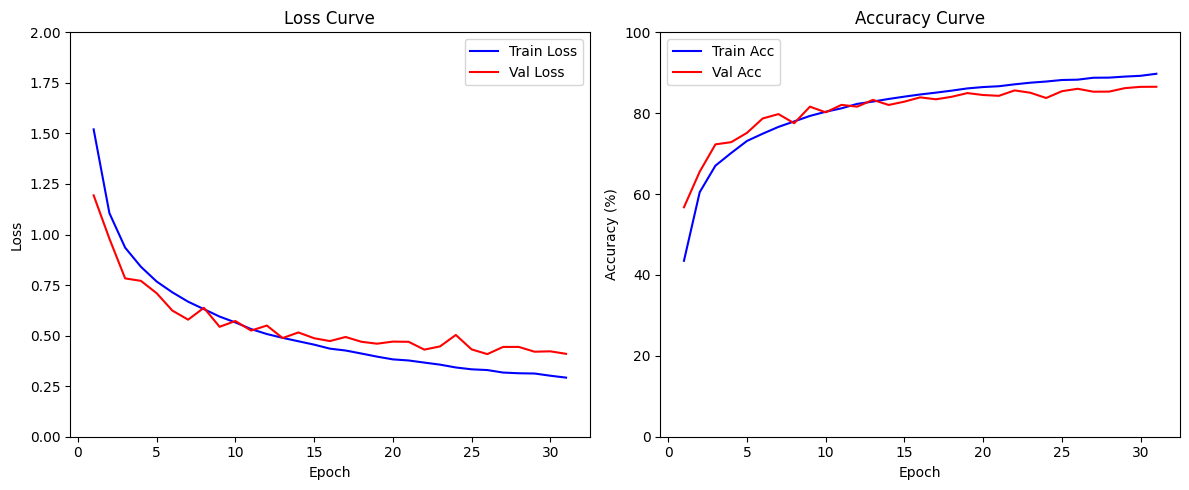

Test Loss: 0.4378, Test Accuracy: 85.13%


In [ ]:
# Train + Validate
train_losses, val_losses, train_accs, val_accs = train_model(model, loaders, criterion, optimizer, num_epochs=50)

# Plot curves
plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

# Final test
test_model(model, loaders['test'])

### Vision Transformer results

Epoch [1/50] Train Loss: 1.7881, Train Acc: 35.06% Val Loss: 1.5704, Val Acc: 44.56%
Epoch [2/50] Train Loss: 1.4827, Train Acc: 46.65% Val Loss: 1.3973, Val Acc: 50.22%
Epoch [3/50] Train Loss: 1.3539, Train Acc: 51.49% Val Loss: 1.3675, Val Acc: 50.56%
Epoch [4/50] Train Loss: 1.2661, Train Acc: 54.62% Val Loss: 1.3057, Val Acc: 54.14%
Epoch [5/50] Train Loss: 1.1779, Train Acc: 57.80% Val Loss: 1.2242, Val Acc: 55.36%
Epoch [6/50] Train Loss: 1.1200, Train Acc: 59.85% Val Loss: 1.2157, Val Acc: 57.84%
Epoch [7/50] Train Loss: 1.0693, Train Acc: 61.42% Val Loss: 1.2206, Val Acc: 56.16%
Epoch [8/50] Train Loss: 1.0204, Train Acc: 63.71% Val Loss: 1.1855, Val Acc: 58.68%
Epoch [9/50] Train Loss: 0.9680, Train Acc: 65.43% Val Loss: 1.1932, Val Acc: 58.64%
Epoch [10/50] Train Loss: 0.9233, Train Acc: 67.05% Val Loss: 1.1423, Val Acc: 60.02%
Epoch [11/50] Train Loss: 0.8807, Train Acc: 68.25% Val Loss: 1.1833, Val Acc: 60.42%
Epoch [12/50] Train Loss: 0.8439, Train Acc: 69.56% Val Loss: 1

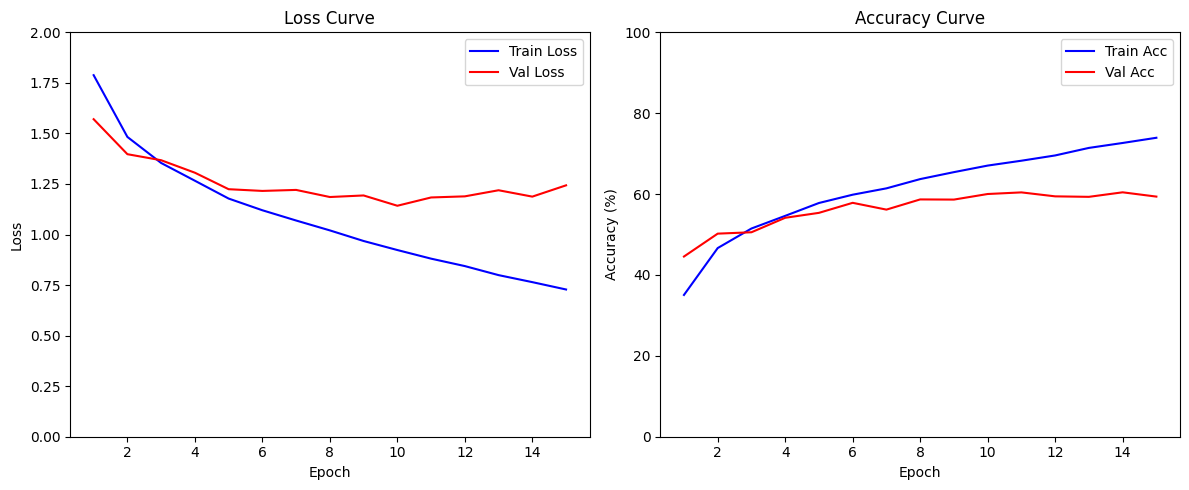

Test Loss: 1.1446, Test Accuracy: 59.52%


In [ ]:
# Train + Validate
train_losses, val_losses, train_accs, val_accs = train_model(model_vit, loaders, criterion, optimizer_vit, num_epochs=50)

# Plot curves
plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

# Final test
test_model(model_vit, loaders['test'])

### Comparison

Our experiments on CIFAR-10 reveal distinct performance characteristics between the two model architectures. The CNN was trained over multiple epochs and achieved a final test accuracy of 85.13%. The training and validation loss curves for the CNN consistently decreased over time, while the training and validation accuracy curves showed a steady improvement with minimal signs of overfitting. This behavior suggests that the CNN, with its sequential convolutional layers and pooling operations, effectively learns the necessary hierarchical features from small images. Additionally, the CNN exhibits faster training times and convergence, making it computationally efficient, a key advantage in practical deployment. The regularisation techniques, including dropout, help the CNN generalise well, as reflected in its strong performance on the test set.

In contrast, the Vision Transformer (ViT) model displayed a different training dynamic. Although its training loss decreased, the validation loss plateaued relatively early—triggering early stopping at epoch 15. This early stopping mechanism, designed to prevent overfitting by halting training when no improvement in validation loss is observed for a preset number of epochs, indicates that the ViT reached its optimal performance sooner. The final test accuracy of the ViT, at 59.52%, was significantly lower than that of the CNN in our experiments. Visualisations of loss and accuracy curves for the ViT show a larger gap between training and validation metrics, which suggests that the model struggled to generalise. The lack of inherent spatial inductive bias in the transformer architecture, combined with the relatively small dataset of CIFAR-10, appears to have limited the ViT’s overall performance.

## Discussion & Insights

The difference in performance between the CNN and the ViT models can be largely explained by the distinct designs of their architectures and the scale of data they require. The CNN relies on convolutional layers that naturally take advantage of the local spatial relationships in images. This means that CNNs are very effective at identifying basic features like edges and textures, which are particularly important when working with smaller images such as those found in the CIFAR-10 dataset. Additionally, the CNN builds up from these low-level features to capture more complex patterns through its hierarchical structure. As a result, it achieves a notably high test accuracy of 85.13%, demonstrating strong learning and generalisation capabilities given the dataset’s characteristics. Furthermore, the CNN not only performs well but also trains faster due to its efficient use of local operations, providing a clear advantage in computational efficiency and practical deployment.

In contrast, the Vision Transformer (ViT) takes a different approach by first breaking an image into patches and then processing these patches as a sequence through self-attention mechanisms. Although this method has shown excellent results on large-scale datasets, it lacks the inherent local inductive bias found in CNNs. Without this built-in ability to focus on local features, the ViT may struggle to effectively learn discriminative features from smaller or lower-resolution datasets like CIFAR-10. The early stopping observed during training—caused by the validation loss plateauing—further suggests that the ViT quickly reaches a performance ceiling, likely due to insufficient data. Even when advanced data augmentation or pretraining on larger datasets might enhance its performance, under the current experimental conditions the CNN remains the more effective and efficient choice.

### Recommendations

Based on the comparative evaluation of our CNN and Vision Transformer (ViT) models on CIFAR-10.

For the CNN, although it already exhibits strong performance, further hyperparameter tuning may deliver incremental accuracy improvements. Experimenting with different dropout rates or learning rate schedules could further optimise its generalisation capability. Moreover, exploring additional regularisation techniques, such as L2 weight decay or improved batch normalisation strategies, might enhance its stability on unseen data.

For the ViT model, incorporating aggressive and varied data augmentation techniques, such as random cropping, rotation, or mixup,could mitigate its challenge of lacking inherent spatial inductive biases. Pre-training the ViT on a larger, diverse dataset may also boost its ability to learn robust feature representations, which can then be fine-tuned for CIFAR-10. Additionally, extending the training period while fine-tuning early stopping patience could provide the model with additional time to improve its validation performance.

## Concluding Remarks

In summary, our comparative analysis of CNN and Vision Transformer models on CIFAR-10 highlights the strengths of classical convolutional architectures for small-scale image classification tasks. The CNN demonstrated robust performance, achieving an 85.13% test accuracy by effectively leveraging local spatial features through its layered structure and pooling operations. Its smooth training dynamics and steady convergence underline the benefits of inherent inductive biases that are well-suited to the CIFAR-10 dataset.

Conversely, the ViT model, which utilises self-attention to capture global relationships, underperformed relative to the CNN. Its early stopping behavior and the noticeable gap between training and validation metrics suggest that it struggles to learn optimal representations with limited data and resolution. This underscores the challenges of applying transformer-based models on smaller datasets without additional strategies such as extensive data augmentation or pre-training on larger datasets.

Overall, these findings emphasise the importance of aligning model architecture with the inherent characteristics of the data. While the ViT holds promise for large-scale applications, the CNN emerges as the more effective choice for CIFAR-10. Future work should explore advanced training techniques and hybrid approaches that may combine the benefits of both architectures.